<a href="https://colab.research.google.com/github/IngyBadawi/Image-Segmentation/blob/main/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment #2 Image Segmentation

Imports

In [1]:
import numpy as np
import math

#For visualization
from matplotlib import image 
from matplotlib import pyplot as plt
import scipy.io
from PIL import Image
import random

#For unzipping
from zipfile import ZipFile
import glob

#For image segmantaion
import cv2 as cv
import os

## 1. Download the Dataset and Understand the Format

* If working on Google Collab

In [3]:
!wget -q {"http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"}
!tar -xzf /content/BSR_bsds500.tgz

# Creating the output directory
!mkdir '/content/output'
!mkdir '/content/output/Ground-Truth'

* If working on local host

In [ ]:
## Unzip and extract data
data = ZipFile('BSR.zip', 'r')

#Get complete listing of the zip archive contents
dataList=data.namelist()

# extracting all the files
data.extractall()

## Create 'content' directory to save 'output' directory inside
# Directory
directory = "content"
    
# Parent Directory path
parent_dir = "."

# Path
path = os.path.join(parent_dir, directory) 
if(not os.path.exists(path)):
    os.mkdir(path)

## Create 'output' directory to save all outputs inside
directory = "output"
    
# Parent Directory path
parent_dir = "./content"
    
# Path
path = os.path.join(parent_dir, directory) 
if(not os.path.exists(path)):
    os.mkdir(path)

## Create 'Ground Truth' directory
directory = "Ground-Truth"
    
# Parent Directory path
parent_dir = "./content/output"
    
# Path
path = os.path.join(parent_dir, directory) 
if(not os.path.exists(path)):
    os.mkdir(path)

* Unzip and extract images

In [4]:
#Get the images for training
train = sorted(glob.glob("BSR/BSDS500/data/images/train/**/*.jpg", recursive=True))

#Get the images for testing
test = sorted(glob.glob("BSR/BSDS500/data/images/test/**/*.jpg", recursive=True))
test = test[0:50]

#Get the ground-truth for training
gt_train = sorted(glob.glob("BSR/BSDS500/data/groundTruth/train/**/*.mat", recursive=True))

#Get the ground-truth for testing
gt_test = sorted(glob.glob("BSR/BSDS500/data/groundTruth/test/**/*.mat", recursive=True))
gt_test = gt_test[0:50]

## 2. Visualize the image and the ground truth segmentation

In [42]:
def get_ground_truth_images(index, dataset):

  # Loading the ground truth images from the corresponding .mat file
  ground_truth_img = scipy.io.loadmat(dataset[index])

  #print(ground_truth_img)
  ground_truth_img = np.squeeze(ground_truth_img['groundTruth'])
  gt_images = []

  #Appending the ground truth segmentations in the list 
  for i in range(5):
    curr_ground_truth = ground_truth_img[i][0][0][0]
    gt_images.append(curr_ground_truth)
  
  return gt_images

In [43]:
def visualize_image(index, dataset):
  my_path = '/content/output/Ground-Truth' # Defining the path to save the images later
  my_file = str(dataset).lower() + ' ' + str(index) + ' visualization' # Defining the file name to save the images later
  fig, axarr = plt.subplots(2,3,figsize=(20, 10))

  # Specifying which dataset to use depending on the parameter 'dataset' sent to the function
  if dataset == "TRAIN":
    normal_dataset = train
    gt_dataset = gt_train
  if dataset == "TEST":
    normal_dataset = test
    gt_dataset = gt_test

  images = [] # A list to store the image and its ground truth segmentation to use it in plotting them
  normal_img = image.imread(normal_dataset[index])

  images.append(normal_img)
  gt_images = get_ground_truth_images(index, gt_dataset) # Getting the ground truth of the image
  images = images + gt_images # Appending them to the list of images to be displayed
  
  # Loop through the list and plot each image
  for i in range(len(images)):
    row = i // 3
    col = i % 3
    if i == 0:
      axarr[row][col].imshow(images[0])
    axarr[i // 3][i % 3].imshow(images[i], interpolation='nearest')
  
  # Showing the figure and saving it to the output directory
  fig.suptitle(my_file, fontsize=16)
  plt.savefig(os.path.join(my_path, my_file), bbox_inches = 'tight')
  plt.show()
  plt.close()
  return

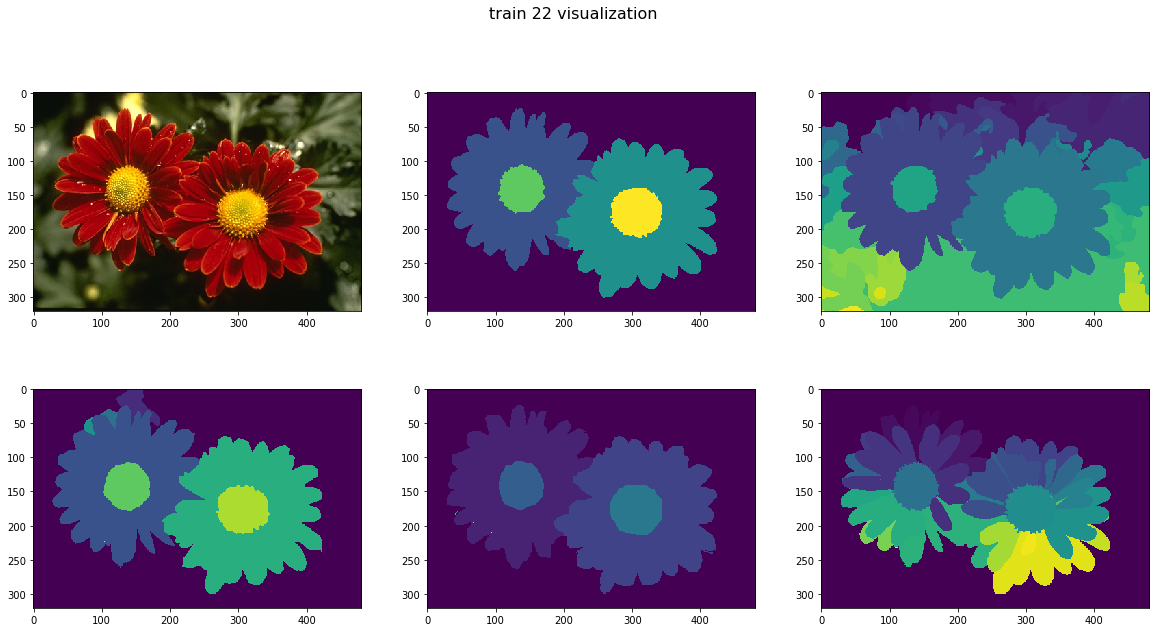

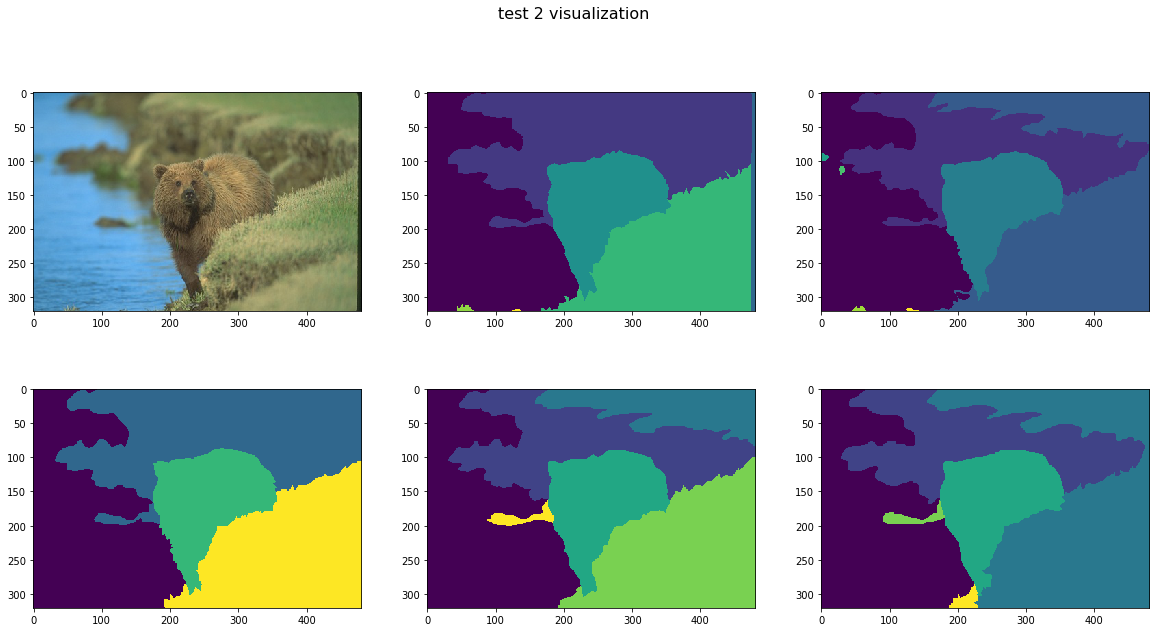

In [45]:
# A function that returns n random indices in the range between 0 and 50 (since the test dataset is only 50 images)
def get_random_images(n):
  rands = random.sample(range(0, 50), n)
  return rands

datasets = ["TRAIN", "TEST"]
randoms = get_random_images(2) # Calling the above function to get 2 random images to visualize

# Visualize a sample from training dataset and a sample from test data set alternatively
for i in range(len(randoms)):
  visualize_image(randoms[i], datasets[i & 1])

* If working on Google Collab

In [ ]:
# Zipping and downloading output folder as output.zip
#!zip -qq -r /content/output.zip /content/output
#files.download("/content/output.zip")

## 3. Segmentation Using K-means

Every image pixel is a feature vector of 3-dimension {R, G, B}. We will 
use this feature representation to do the segmentation.

### * Our own implementation of K-means

In [ ]:
#K-means
def Kmeans(D,k,trials):

  #initialze k empty sets
  sets=[set() for i in range(k)]

  #initialize labels vector
  n = D.shape[0]
  labels= np.zeros(n)
  labels = labels.astype(np.int32)

  #randomly select k centroids
  random_indices = np.random.choice(n, size=k, replace=False)
  means = D[random_indices, :]

  itr=0
  temp = [set() for i in range(k)]

 #for t in range(trials): -> needs number of trials to be exact
  while(1): 
    itr=itr+1
    
    #Cluster Assignment
    for i in range(n): #for every data point
      min=math.inf
      for j in range(k): #for every centroid
        dist=(D[i]-means[j])**2
        dist = np.sum(dist)
        dist = np.sqrt(dist)
        if(dist<min):  #Assign to closest centroid
          min=dist
          min_j=j
      sets[min_j].add(i)
      labels[i]=min_j
      
    #Centroid Update
    for i in range(k):
      length=len(sets[i])
      sum=np.zeros((1,k))
      if(length>0): 
        for j in sets[i]:
          sum=sum + D[j]
        means[i]=sum/length

    #Check if there's no update in the cluster assignment
    if(itr>1):
      count=0
      for i in range(k):
        count = count + len(sets[i] - temp[i])
      if(count==0):
        break

    #store and clear sets for next iteration    
    for i in range(k):
      temp[i]=sets[i].copy()
      sets[i].clear()
    
    return labels, means

### a. Apply K-means to obtain 3,5,7,9,11 clusters

In [ ]:
def image_segmantaion(array, K, path):

    #Array to store images
    result=np.zeros([],int)

    #Array to store labels
    img = cv.imread(array[0])
    Z = img.reshape((-1,3))
    labels=np.zeros((len(array),Z.shape[0]))

    #Get Current Directory to save images
    path = os.path.join(path , str(K))
    if(not os.path.exists(path)):
        os.mkdir(path)

    #Segmanting all 200 train images
    for i in range(len(array)):
        
        img = cv.imread(array[i])
        Z = img.reshape((-1,3))
        
        # convert to np.float32
        Z = np.float32(Z)
        
        # define criteria, number of clusters(K) and apply kmeans()
        criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        ret, label, center=cv.kmeans(Z,K,None,criteria,10,cv.KMEANS_RANDOM_CENTERS)

        #our own k-means
        #label, center = Kmeans(Z,K)
        
        #Store labels
        labels[i]=label.reshape(1,label.shape[0]) 

        # Now convert back into uint8, and make original image
        center = np.uint8(center)
        res = center[label.flatten()]
        seg_img = res.reshape((img.shape))

        #Save them to an array
        #result=np.append(result,res2)

        #Save segmented images 
        #if len(os.listdir('path')) != 0: (If segmentations changed for same K, then they have to be replaced)
        new_name=os.path.basename(array[i])
        new_name= 'seg_'+ new_name
        cv.imwrite(os.path.join(path ,new_name), seg_img)

    return labels


In [ ]:
## Create a directory to save all segmented images inside
# Directory
directory = "Segmented-Images"
    
# Parent Directory path
parent_dir = "./content/output"
    
# Path
path = os.path.join(parent_dir, directory) 
if(not os.path.exists(path)):
    os.mkdir(path)

## Image Segmentation
K=[3,5,7,9,11]
cluster_ids_train=[np.array([]) for i in K] #Array of all labels
j=0
for i in K:
    cluster_ids_train[j] = image_segmantaion(train, i, path)
    j+=1

### b. Evaluation using F-measure and Conditional Entropy

* My implementation of F-measure, but it takes different inputs than what we have. 

(clusters and ground truth themselves not cluster ids and labels)


In [ ]:
def sizeOfIntersection(cluster,truth):
  size=0
  n=cluster.shape[0]

  for i in range(n):
    if(cluster[i].tolist() in truth.tolist()):
      size+=1

  return size

# 2. Purity
def Purity(clusters, truths, numElements):
  #Total Purity
  purity=0 

  #Name each cluster
  k=len(clusters)
  results = np.zeros((k,2), dtype=object)

  for i in range(k):
    max= -1
    for j in range(len(truths)):
      temp=sizeOfIntersection(clusters[i], truths[j])
      if(temp>max):
        max=temp
        max_T=j
    results[i][0]=max_T #index of best matching class
    results[i][1]=max   #number elements matched from best matching class

  #Calculate Purity
  purity_i = np.zeros(k)
  for i in range(k):
    purity_i[i]=results[i][1]/len(clusters[i])
    purity+=purity_i[i]*len(clusters[i])/numElements
  return results,purity_i, purity

# 5. F-measure
def FMeasure(clusters, truths, results, prec):
  F=0
  k=len(clusters)

  #Calculate Recall
  rec=np.zeros(k)
  for i in range(k):
    j=results[i][0]
    rec[i]=results[i][1]/(len(truths[j]))

  #Calculate F  
  for i in range(k):
    temp=(2*prec[i]*rec[i])/(prec[i]+rec[i])
    F+=temp
  F/=k

  return F

In [ ]:
def evaluate(img_indx, K, dataset):

    #Map K with its index
    k = int((K-3)/2)

    # Specifying which dataset to use depending on the parameter 'dataset' sent to the function
    if dataset == "TRAIN":
        cluster_ids = cluster_ids_train[k][img_indx]  #get cluster ids of segmented image (training)
        gt_dataset = gt_train
    elif dataset == "TEST":
        cluster_ids = cluster_ids_test[k][img_indx]  #get cluster ids of segmented image (testing)
        gt_dataset = gt_test
    
    #Get corresponding ground truth image
    gt_img = scipy.io.loadmat(gt_dataset[img_indx])
    gt_img = np.squeeze(gt_img['groundTruth'])

    #Use first ground truth image to get image shape
    gt_img_for_shape = gt_img[0][0][0][0]
    x=gt_img_for_shape.shape[0] 
    y=gt_img_for_shape.shape[1]

    #Reshape labels vector of segmented image
    cluster_ids = cluster_ids.reshape((x,y))
    print(cluster_ids)
    plt.imshow(cluster_ids)
    plt.show() 

    #number of ground truth segments
    M = gt_img.shape[0]

    #Loop on all ground truth images, report measures M times (Call F-measure and Conditional Entropy)
    for i in range(M):
        curr_gt_labels = gt_img[i][0][0][0]     #ground truth labels (number i/M)
        print(curr_gt_labels)
        plt.imshow(curr_gt_labels)
        plt.show()

    #Get average of the M trials


[[3. 3. 3. ... 3. 3. 3.]
 [3. 3. 3. ... 3. 3. 3.]
 [3. 4. 4. ... 3. 3. 3.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 1. 0.]]


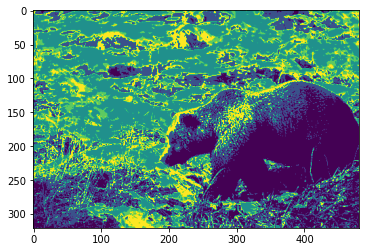

[[ 1  1  1 ...  3  3  3]
 [ 1  2  2 ...  3  3  3]
 [ 2  2  2 ...  3  3  3]
 ...
 [52 52 52 ... 52 52 52]
 [52 52 52 ... 52 52 52]
 [52 52 52 ... 52 52 52]]


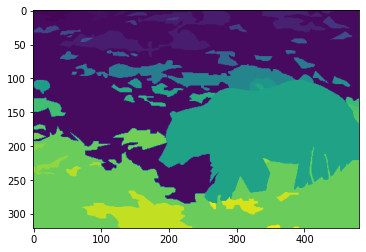

[[ 1  1  1 ...  4  4  4]
 [ 1  1  2 ...  4  4  4]
 [ 2  2  2 ...  4  4  4]
 ...
 [37 37 37 ... 37 37 37]
 [37 37 37 ... 37 37 37]
 [37 37 37 ... 37 37 37]]


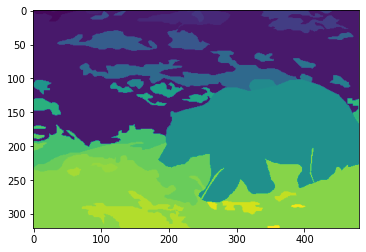

[[ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 [ 1  1  1 ...  1  1  1]
 ...
 [15 15 15 ... 15 15 15]
 [15 15 15 ... 15 15 15]
 [15 15 15 ... 15 15 15]]


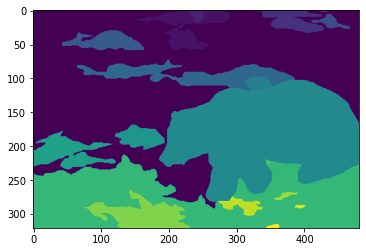

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


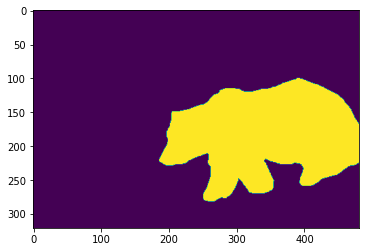

[[ 1  1  1 ...  2  2  2]
 [ 1  1  1 ...  2  2  2]
 [ 1  1  1 ...  2  2  2]
 ...
 [17 17 17 ... 22 22 22]
 [17 17 17 ... 22 22 22]
 [17 17 17 ... 22 22 22]]


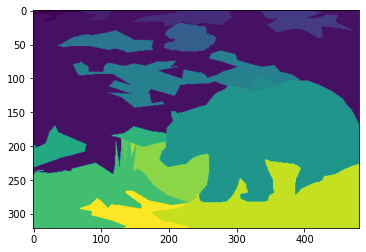

In [ ]:
#Test evaluate for one image
img_indx=2
K=5
dataset="TRAIN"
evaluate(img_indx, K, dataset)

## 4. Big Picture

## 5. Extra

In the previous parts, we used the color features RGB. We did not
encode the layout of the pixels. We want to modify that for K-means 
clustering to encode the spatial layout of the pixels.



i. Suggest a way to modify the feature vector to include spatial 
layout

In [ ]:
def image_segmantaion_modified(array, K, path):

    #Array to store images
    result=np.zeros([],int)

    #Array to store labels
    img = cv.imread(array[0])
    Z = img.reshape((-1,3))
    labels=np.zeros((len(array),Z.shape[0]))

    #Get Current Directory to save images
    path = os.path.join(path , str(K))
    if(not os.path.exists(path)):
        os.mkdir(path)

    #Segmanting all 200 train images
    for i in range(len(array)):
        
        #read image and save its shape
        img = cv.imread(array[i])
        shape = img.shape

        #store number of rows and columns
        x = img.shape[0] #number of rows
        y = img.shape[1] #number of columns
        N = x*y          #total number of pixels

        #features vector
        features = img.reshape((-1,3))
        features = np.c_[ features, np.zeros(N), np.zeros(N)]  # add 2 extra columns

        # include spatial layout to feature vector
        k=0
        for r in range(x):     #rows
            for c in range(y): #columns
                features[k][3]=r
                features[k][4]=c
                k+=1
        
        # convert to np.float32
        features = np.float32(features)
        
        # define criteria, number of clusters(K) and apply kmeans()
        criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
        ret, label, center=cv.kmeans(features, K, None, criteria, 10, cv.KMEANS_RANDOM_CENTERS)
        
        #Store labels
        labels[i]=label.reshape(1,label.shape[0])

        # Now convert back into uint8, and create segmented image
        center = np.uint8(center)
        center_RGB = center[:,0:3]
        res = center_RGB[label.flatten()]
        seg_img = res.reshape((shape))

        #Save them to an array
        #result=np.append(result,res2)

        #Save segmented images 
        #if len(os.listdir('path')) != 0: (If segmentations changed for same K, then they have to be replaced)
        new_name=os.path.basename(array[i])
        new_name= 'modified_seg_'+ new_name 
        cv.imwrite(os.path.join(path ,new_name), seg_img)

    return labels


In [ ]:
## Create a directory to save all modified segmented images inside
# Directory
directory = "Modified-Segmented-Images"
    
# Parent Directory path
parent_dir = "./content/output"
    
# Path
path = os.path.join(parent_dir, directory) 
if(not os.path.exists(path)):
    os.mkdir(path)

## Image Segmentation
K=[3,5,7,9,11]

labels=[np.array([]) for i in K] #Array of all labels
j=0
for i in K:
    labels[j] = image_segmantaion_modified(train, i, path)
    j+=1

(200, 154401)
(200, 154401)
(200, 154401)
(200, 154401)
(200, 154401)


ii. Contrast the results you obtained in 4.a to the results you 
obtained by considering the spatial layout.